## Resources
- https://xgboost.readthedocs.io/en/stable/get_started.html
- https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

In [1]:
%reload_kedro

2023-10-08 23:19:17,177 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: C:\Users\Dushku\PycharmProjects\monash-datahack-2023
2023-10-08 23:19:17,302 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-10-08 23:19:17,321 - kedro.framework.hooks.manager - INFO - Registered hooks from 1 installed plugin(s): kedro-telemetry-0.2.5
2023-10-08 23:19:17,379 - kedro.extras.extensions.ipython - INFO - ** Kedro project Monash datahack 2023
2023-10-08 23:19:17,379 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


C:\Users\Dushku\PycharmProjects\monash-datahack-2023\venv\lib\site-packages\kedro\framework\context\context.py:344: UserWarning: Credentials not found in your Kedro project config.
No files found in ['C:\\Users\\Dushku\\PycharmProjects\\monash-datahack-2023\\conf\\base', 'C:\\Users\\Dushku\\PycharmProjects\\monash-datahack-2023\\conf\\local'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [2]:
df = catalog.load('encoded_data_not_recycled')

2023-10-08 23:19:17,385 - kedro.io.data_catalog - INFO - Loading data from `encoded_data_not_recycled` (CSVDataSet)...


In [3]:
df.head()

,y,Jurisdiction_encoded,Sub-stream,Category_encoded,Type_encoded,Management_encoded,Fate_encoded,ds_encoded
0,4748,0,3,1,7,2,0,14
1,4748,0,9,1,7,2,0,14
2,4748,0,3,1,68,2,0,14
3,4748,0,9,1,68,2,0,14
4,4748,0,3,1,68,2,0,14


In [4]:
df.columns

Index(['y', 'Jurisdiction_encoded', 'Sub-stream', 'Category_encoded',
       'Type_encoded', 'Management_encoded', 'Fate_encoded', 'ds_encoded'],
      dtype='object')

XGBoost requires special handling for categorical data
https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

In [5]:
cat_columns = ['Jurisdiction_encoded', 'Sub-stream', 'Category_encoded', 'Type_encoded', 'Management_encoded', 'Fate_encoded']
for column in cat_columns:
    df[column].astype("category")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45680 entries, 0 to 45679
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   y                     45680 non-null  int64
 1   Jurisdiction_encoded  45680 non-null  int64
 2   Sub-stream            45680 non-null  int64
 3   Category_encoded      45680 non-null  int64
 4   Type_encoded          45680 non-null  int64
 5   Management_encoded    45680 non-null  int64
 6   Fate_encoded          45680 non-null  int64
 7   ds_encoded            45680 non-null  int64
dtypes: int64(8)
memory usage: 2.8 MB


In [7]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [8]:
X = df.loc[:, df.columns != 'y']
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", enable_categorical=True)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse=mean_squared_error(y_test, y_pred)

print(mse)

561293.5449495318


In [9]:
r2_score_1 = r2_score(y_test, y_pred)

print(r2_score_1)

0.9191025455654238


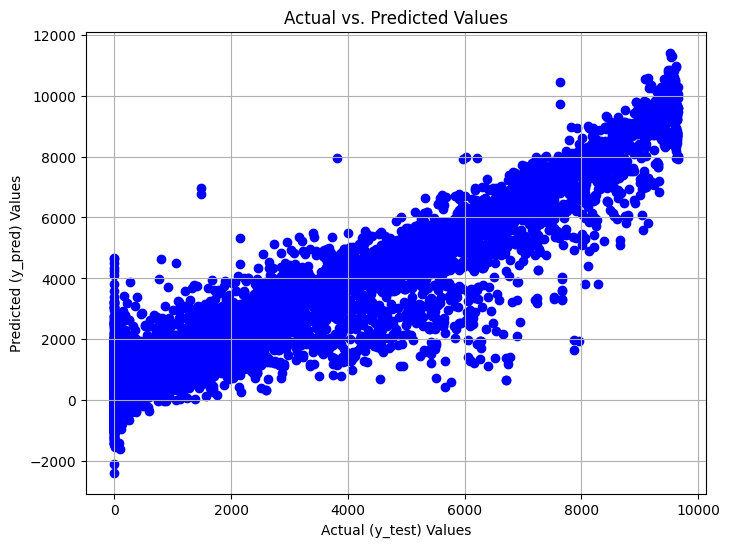

In [10]:
import matplotlib.pyplot as plt
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', marker='o')
plt.xlabel('Actual (y_test) Values')
plt.ylabel('Predicted (y_pred) Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", 
                             enable_categorical=True, 
                             learning_rate=0.03, 
                             n_estimators=1000,
                             colsample_bytree = 1.0, 
                             gamma = 1.5, 
                             max_depth = 5, 
                             min_child_weight = 1, 
                             subsample = 0.8
                            )

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse=mean_squared_error(y_test, y_pred)

print(mse)

r2_score(y_test, y_pred)

793990.3435949337


0.8855646956562809

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

def gridsearch():
    skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", learning_rate=0.01, enable_categorical=True, n_estimators=500)
    params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
    grid = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='r2', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3)
    grid.fit(X_train, y_train)
    print("Best estimator: ")
    print(grid.best_estimator_)
    print("Best parameters: ")
    print(grid.best_params_)
    
gridsearch()

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


C:\Users\Dushku\PycharmProjects\monash-datahack-2023\venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Report:
    - Pre-processing
        - Differences between data subsets
        - Balancing histogram
        - Null
        - Graphs
        - etc..
    - Models
        - Parameters
        
Ensemble:
    - https://machinelearningmastery.com/weighted-average-ensemble-with-python/
    - Weighted average 
    
    - XGBoost
    - LightGBM
    - catboost